In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import pearsonr

### Data Understanding

In [29]:
# Load the dataset
url = "https://raw.githubusercontent.com/kaawaaii/Prediksi-harga-rumah/main/HargaRumah_Cimanggis_300.csv"
df = pd.read_csv(url)

In [30]:
# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())
print(df.dtypes)

   k_tidur  l_tanah  l_bangunan  k_mandi     daerah      harga
0        3       63          62        2  Cimanggis  770000000
1        3       90          70        2  Cimanggis  897000000
2        3       60          54        2  Cimanggis  745000000
3        3       62          56        2  Cimanggis  823000000
4        3       63          62        2  Cimanggis  775000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   k_tidur     300 non-null    int64 
 1   l_tanah     300 non-null    int64 
 2   l_bangunan  300 non-null    int64 
 3   k_mandi     300 non-null    int64 
 4   daerah      300 non-null    object
 5   harga       300 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 14.2+ KB
None
          k_tidur    l_tanah  l_bangunan     k_mandi         harga
count  300.000000  300.00000  300.000000  300.000000  3.000000e+02
mean    

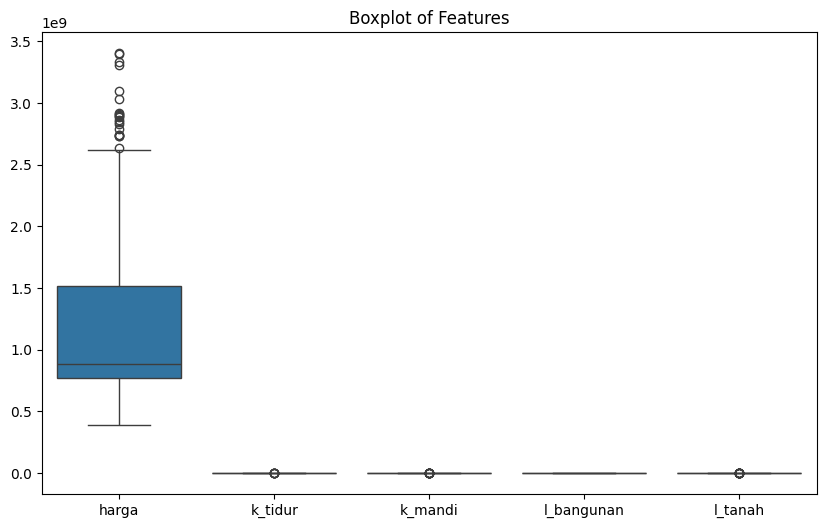

In [21]:
# Check for outliers
plt.figure(figsize=[10, 6])
sns.boxplot(data=df[['harga', 'k_tidur', 'k_mandi', 'l_bangunan', 'l_tanah']])
plt.title('Boxplot of Features')
plt.show()

### Data Preparation

In [22]:
# Remove outliers based on price (e.g., prices beyond 3 standard deviations from the mean)
z_scores = np.abs((df['harga'] - df['harga'].mean()) / df['harga'].std())
df = df[z_scores < 3]

In [23]:
# Define the features and target variable
X = df[["k_tidur", "k_mandi", "l_bangunan", "l_tanah"]]  # added l_bangunan and l_tanah as features
y = df["harga"]


In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling

In [25]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=300,
                      random_state=42)

### Evaluation

In [32]:
# Make predictions
y_pred = best_rf.predict(X_test_scaled)

# Evaluate the model
pearson_coef, p_value = pearsonr(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [33]:
print(f'Koefisien Korelasi Pearson: {pearson_coef}')
print(f'P-value: {p_value}')
print(f"R-squared (R²): {r2:.2f}")

Koefisien Korelasi Pearson: 0.9808832734055865
P-value: 6.256802282786028e-43
R-squared (R²): 0.96


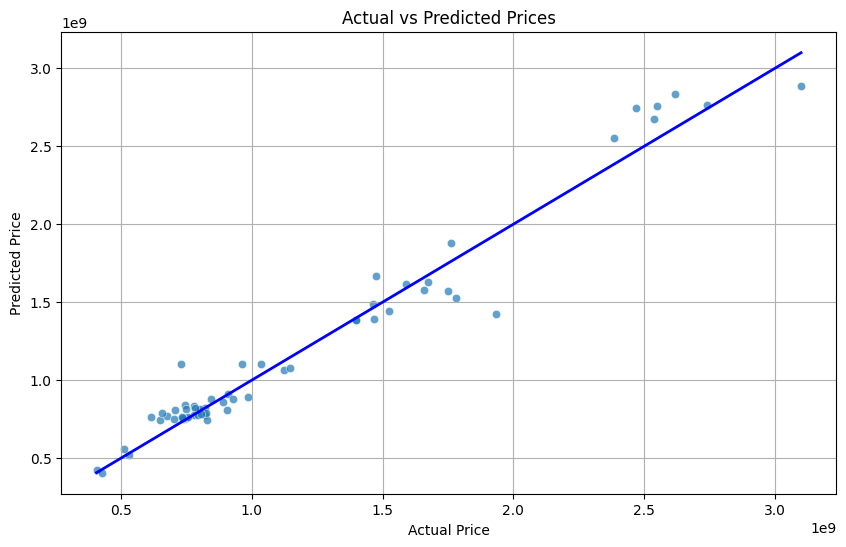

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Add a blue line indicating a perfect linear relationship (y = x)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='blue', linewidth=2)

plt.show()

### Deployment

In [26]:
# Function to predict house price based on user input
def predict_house_price(bedrooms, bathrooms, building_area, land_area):
    input_data = np.array([[bedrooms, bathrooms, building_area, land_area]])
    input_data_scaled = scaler.transform(input_data)
    predicted_price = best_rf.predict(input_data_scaled)
    return predicted_price[0]

In [12]:
1# Get user input for number of bedrooms, bathrooms, building area, and land area
bedrooms = float(input("Enter the number of bedrooms: "))
bathrooms = float(input("Enter the number of bathrooms: "))
building_area = float(input("Enter the building area in square meters: "))
land_area = float(input("Enter the land area in square meters: "))

Enter the number of bedrooms: 3
Enter the number of bathrooms: 3
Enter the building area in square meters: 36
Enter the land area in square meters: 60


In [13]:
def format_price(price):
    if price >= 1_000_000_000:
        return f"{price / 1_000_000_000:.2f} miliar rupiah"
    else:
        return f"{price / 1_000_000:.2f} juta rupiah"

# Predict the house price
predicted_price = predict_house_price(bedrooms, bathrooms, building_area, land_area)
formatted_price = format_price(predicted_price)
print(f"The predicted house price is: {formatted_price}")

The predicted house price is: 535.82 juta rupiah


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [14]:
# Compare actual vs predicted prices for test data
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Calculate absolute errors
comparison['Selisih Harga'] = abs(comparison['Actual'] - comparison['Predicted'])

# Sort by absolute error and take the 5 best predictions
best_comparisons = comparison.nsmallest(5, 'Selisih Harga')

# Display the best comparisons as a table
print(best_comparisons.to_string(index=False))

   Actual    Predicted  Selisih Harga
819299030 8.200849e+08   7.858272e+05
910507187 9.090147e+08   1.492441e+06
777244277 7.738851e+08   3.359195e+06
756145865 7.622416e+08   6.095783e+06
529295829 5.217931e+08   7.502772e+06


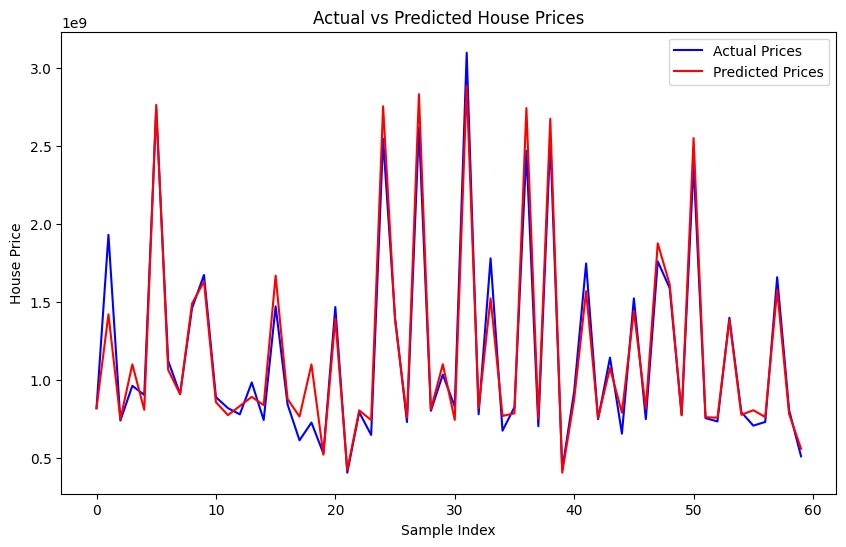

In [15]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison['Actual'].values, label='Actual Prices', color='b')
plt.plot(comparison['Predicted'].values, label='Predicted Prices', color='r')
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.legend()
plt.show()
